# Include Toolbox

In [1]:
# note: burst tal passer ikke med polynomials nødvendigvis, for 1 gør det dog. skal fixes i load måske.
# full image range, sample: 
# 1:15240
# 1:25330

In [11]:
"""
    get_best_polynomial(burst_number::Int, meta::Dict)

Computes the index of meta["dc_estimate"] and meta["azimuth_fm_rate"] 

# Arguments
- `burst_number::Int`: The number of the burst of interest.
- `meta::Dict`:  Meta information from the Sentinel-1 SLC image

# Output
- Indeces::Tuple{Int64,Int64}: The indeces of the meta["dc_estimate"] and meta["azimuth_fm_rate"] closest to mid burst time

# Examples:
```jldoctest
julia> meta = Load.slc_meta(path_meta_1);
julia> burst_number = 1
julia> get_best_polynomial(burst_number, meta);
Tuple{Int64,Int64}:
(1, 1)
```
"""
function get_best_polynomial(burst_number, meta)
    t0 = meta["t_start"]
    dc_polynomial_list = meta["burst_meta"]["dc_estimate"]
    fm_polynomial_list = meta["burst_meta"]["azimuth_fm_rate"]
    burst_mid_time = meta["burst_meta"]["burst_times"][burst_number] .+ meta["lines_per_burst"]/(2*meta["azimuth_frequency"])
    dc_time_diff = Array{Float64, 1}(undef, length(dc_polynomial_list))
    fm_time_diff = Array{Float64, 1}(undef, length(fm_polynomial_list))
    for i in range(1, stop=length(fm_polynomial_list))
        dc_time = Load._str_date2float(dc_polynomial_list[i]["azimuthTime"], meta["t_0"])
        fm_time = Load._str_date2float(fm_polynomial_list[i]["azimuthTime"], meta["t_0"])
        dc_time_diff[i] = abs(dc_time - burst_mid_time)
        fm_time_diff[i] = abs(fm_time - burst_mid_time)
    end
    return argmin(dc_time_diff), argmin(fm_time_diff)
end
"""
    mid_burst_speed(precise_orbit::Dict, meta::Dict)

Computes the speed (not velocity) of the satellite at all mid burst times.

# Arguments
- `precise_orbit:Dict`: Precise orbit data
- `meta::Dict`:  Meta information from the Sentinel-1 SLC image

# Output
- `v_mid::Array{Float64,1}`: N-element Array of speeds at midburst time, where N is the number of bursts.

# Examples:
```jldoctest
julia> meta = Load.slc_meta(path_meta_1);
julia> precise_orbit = Load.precise_orbit(path_pod_1, meta["t_0"]);
julia> burst_number = 1
julia> mid_burst_speed(precise_orbit, meta)[burst_number]
7588.187233437368
```
"""

function mid_burst_speed(precise_orbit, meta)
    t_start = meta["t_start"]
    t_stop = meta["t_stop"]
    
    state_vectors_poly, state_vectors_mean, state_vectors_std = Geometry.satellite_trajectory(precise_orbit..., t_start, t_stop)
    
    time_mid_burst = meta[ "burst_meta"]["burst_times"].+ meta["lines_per_burst"]/(2*meta["azimuth_frequency"])
    
    v_mid = [Geometry.polyval_state_vectors(state_vectors_poly,time,state_vectors_mean, state_vectors_std) for time in time_mid_burst]
    v_mid = [ sqrt(elem[4:6]'*elem[4:6]) for elem in v_mid]
end

"""
    get_burst_corners(burst_number::Int, meta::Dict)

Computes the corner indices of a burst. 

# Arguments
- `burst_number::Int`: The number of the burst of interest.
- `meta::Dict`:  Meta information from the Sentinel-1 SLC image

# Output

# Examples:
```jldoctest
julia> meta = Load.slc_meta(path_meta_1);
julia> burst_number = 1
julia> first_index_row, last_index_row, first_index_col, last_index_col = get_burst_corners(burst_number, meta)
julia> print(first_index_row, ", ",last_index_row, ", ",first_index_col, ", ",last_index_col)
32, 1495, 946, 24512
```
"""
function get_burst_corners(burst_number, meta)
    first_index_row = findfirst(x->x!=-1, meta["burst_meta"]["fist_valid_pixel"][burst_number])
    last_index_row = findlast(x->x!=-1, meta["burst_meta"]["last_valid_pixel"][burst_number])
    first_index_col = meta["burst_meta"]["fist_valid_pixel"][burst_number][first_index_row]
    last_index_col = meta["burst_meta"]["last_valid_pixel"][burst_number][last_index_row]
    return first_index_row, last_index_row, first_index_col, last_index_col
end

"""
    deramp(burst_number::Int, meta::Dict, precise_orbit:Dict)

Computes deramped phase, phi, for the given burst number.

# Arguments
- `burst_number::Int`: The number of the burst of interest.
- `meta::Dict`:  Meta information from the Sentinel-1 SLC image
- `precise_orbit:Dict`: Precise orbit data

# Output
- phi::Array{Float64,2}: Array with deramped phase for every pixel in burst

# Examples:
```jldoctest
julia> meta = Load.slc_meta(path_meta_1);
julia> precise_orbit = Load.precise_orbit(path_pod_1, meta["t_0"]);
julia> burst_number = 1
julia> phi = deramp(burst_number, meta, precise_orbit);
1525×23567 Array{Float64,2}:
 6.17566e8  6.17565e8  6.17564e8  …  5.89003e8  5.89001e8  5.89e8   
 ⋮                                ⋱             ⋮                   
 6.28521e8  6.28519e8  6.28518e8  …  5.9945e8   5.99449e8  5.99448e8
```
"""
function deramp(burst_number, meta, precise_orbit)
    # fish out constants and parameters
    c = 299792458
    k_psi = meta["azimuth_steering_rate"] * pi/180
    f_etac_par = meta["burst_meta"]["data_dc_polynomial"][burst_number, :]
    dc_tau0 = meta["burst_meta"]["data_dc_t0"][burst_number]
    k_a_par = meta["burst_meta"]["azimuth_fm_rate_polynomial"][burst_number, :]
    az_fm_rate_tau0 = meta["burst_meta"]["azimuth_fm_rate_t0"][burst_number]
    f_c = meta["radar_frequency"]
    lines_per_burst = meta["lines_per_burst"]
    number_of_samples = meta["number_of_samples"] 
    Delta_t_s = meta["azimuth_time_interval"]
    Delta_tau_s = 1/meta["range_sampling_rate"]
    tau_0 = meta["slant_range_time"]
    v_s = mid_burst_speed(precise_orbit, meta)[burst_number]
    
    # Not sure about tau0 for dc and fm rate, they differ from slant range time tau0, 
    # but using them gives odd results.
    # Alternatively use these one-line functions to use different tau0's
    #k_a(x, param, x0) = param[1] .+ param[2].*(x .- x0) .+ param[3].*(x .- x0).^2
    #f_etac(x, param, x0) = param[1] .+ param[2].*(x .- x0) .+ param[3].*(x .- x0).^2;
    
    #Equations from Miranda 2017 note: "Definition of the TOPS SLC deramping function for products generated by the S-1 IPF"
    row_start, row_end, col_start, col_end = get_burst_corners(burst_number, meta)
    tau = Array{Float64, 1}(undef, col_end - col_start + 1)
    for i in 1:col_end - col_start + 1
        tau[i] = tau_0 + (i + col_start) * Delta_tau_s # Slant range time of ith sample, Eqn. 12
    end

    # Doppler rate equations
    k_s = 2 * v_s/c * f_c * k_psi; # Doppler rate from antenna scanning, Eqn. 4
    k_a = k_a_par[1] .+ k_a_par[2].*(tau .- tau_0) .+ k_a_par[3].*(tau .- tau_0).^2; # Doppler FM rate, Eqn. 11
    alpha = 1 .- k_s ./ k_a; # conversion factor, Eqn. 3
    k_t = k_s ./ alpha; # Doppler Centroid Rate, Eqn. 2

    # Doppler frequency
    f_etac = f_etac_par[1] .+ f_etac_par[2].*(tau .- tau_0) .+ f_etac_par[3].*(tau .- tau_0).^2; # Doppler centroid frequency, Eqn. 13

    # Doppler azimuth time equations
    eta_c = - f_etac ./ k_a; # Beam centre crossing time, Eqn. 7
    tau_mid = tau_0 + number_of_samples/2 * Delta_tau_s
    temp = f_etac_par[1] + f_etac_par[2]*(tau_mid) + f_etac_par[3]*(tau_mid)^2/(k_a_par[1] + k_a_par[2]*(tau_mid) + k_a_par[3]*(tau_mid)^2);
    eta_ref = eta_c .- (- temp); # Reference time, Eqn. 6
    eta = -lines_per_burst/2*Delta_t_s:Delta_t_s:lines_per_burst/2*Delta_t_s # Eqn. 5
    
    # add if statement in order to allow modulating
    #phi = pi * k_t' .* (collect(eta) .- eta_ref').^2 + 2 * pi * f_etac' .* (collect(eta) .- eta_ref');
    phi = pi * k_t' .* (collect(eta) .- eta_ref').^2; # Eqn. 14
end

"""
    reramp(burst_number::Int, meta::Dict, precise_orbit:Dict)

Computes reramped phase, phi, for the given burst number. Similar to deramp function.
See deramp docstring for details

# Examples:
```jldoctest
julia> phi_reramp = reramp(burst_number, meta, precise_orbit)
julia> reramped = deramped_data .* exp.(-im * phi_reramp)
```
"""
function reramp(burst_number, meta, precise_orbit_data)
    phi = -deramp(burst_number, meta, precise_orbit_data)
end

In [1]:
using DelimitedFiles
using Statistics
using Plots
import EzXML
import XMLDict

In [2]:
include("../ToolBox/ToolBox.jl")
include("../path.jl")
using .ToolBox
using .Geometry
using .Load
using .SlcUtil

proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode


### Data paths

In [3]:
path_img1 = master_data_path
path_meta_1 = master_meta_path
path_pod_1 = master_pod_path;

### Load data

In [4]:
meta = Load.slc_meta(path_meta_1);
precise_orbit = Load.precise_orbit(path_pod_1, meta["t_0"]);

In [5]:
first_index_row, last_index_row, first_index_col, last_index_col = get_burst_corners(1, meta)
views = [first_index_row:first_index_row + meta["lines_per_burst"], first_index_col:last_index_col];
data = Load.slc_data(path_img1, views);

proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode


In [6]:
test = SlcRaw(views, meta, data)

SlcRaw:: S1B-IW-VV-Swath3 2017-03-15T05:39:00 View:[32:1556,946:24512]

### Deramp

In [7]:
burst_number = 1
phi = deramp(burst_number, meta, precise_orbit);

UndefVarError: UndefVarError: deramp not defined

### Export to compute spectogram in Matlab

In [35]:
means_original = mean(test.data, dims=2);
real_original = real.(means_original);
imag_original = imag.(means_original);
writedlm("real_original.csv", real_original);
writedlm("imag_original.csv", imag_original);

In [38]:
deramped = copy(test.data) .* exp.(-im * phi)
means_deramped = mean(deramped, dims=2);
real_deramped = real.(means_deramped);
imag_deramped = imag.(means_deramped);
writedlm("real_deramped.csv", real_deramped)
writedlm("imag_deramped.csv", imag_deramped)

In [41]:
phi_reramp = reramp(burst_number, meta, precise_orbit)
reramped = deramped .* exp.(-im * phi_reramp)
means_reramped = mean(reramped, dims=2);
real_reramped = real.(means_reramped);
imag_reramped = imag.(means_reramped);
writedlm("real_reramped.csv", real_reramped)
writedlm("imag_reramped.csv", imag_reramped)

### Development part/trash
#### variables from annotations

In [9]:
## open xml files
doc = EzXML.readxml(path_meta_1)
meta_dict = XMLDict.xml_dict(doc);

In [11]:
[parse(Float64, param) for param in split(meta_dict["product"]["dopplerCentroid"]["dcEstimateList"]["dcEstimate"][1]["dataDcPolynomial"][""])]

3-element Array{Float64,1}:
     23.18285   
 -60805.62      
      6.818214e7

## Make the following cell into function
- should return the index that corresponds to the polynomial closest to midburst time. Then index can be used in choosing correct coefficients outside nomatter whether it is f_etac or k_a
- use correct t0 for f_etac and k_a from polynomials

In [14]:
burst_number = 1
t0 = meta["t_start"]
burst_mid_times = meta["burst_meta"]["burst_times"] .+ meta["lines_per_burst"]/(2*meta["azimuth_frequency"])

10-element Array{Float64,1}:
 52.2694389006
 55.0279959006
 57.7844969006
 60.5451089006
 63.3016099006
 66.0601659006
 68.8207779006
 71.5752239006
 74.3337799006
 77.0943919006

In [33]:
idx=9
abs.(Load._str_date2float(meta["burst_meta"]["dc_estimate_list"][idx]["azimuthTime"], meta["t_0"]) .- burst_mid_times)

10-element Array{Float64,1}:
 21.0949230994      
 18.336366099400003 
 15.579865099400003 
 12.819253099400001 
 10.0627520994      
  7.304196099400002 
  4.543584099399993 
  1.789138099400006 
  0.969417900600007 
  3.7300299006000017

In [34]:
meta["burst_meta"]["dc_estimate_list"][idx]["dataDcPolynomial"][""]

"-1.296565e+01 6.693695e+04 -3.362952e+07"

In [45]:
meta["burst_meta"]["data_dc_t0"][1]

0.005361469856998912

0

In [95]:
c = 299792458
k_psi = parse(Float64, meta_dict["product"]["generalAnnotation"]["productInformation"]["azimuthSteeringRate"]) * pi/180 #add
f_etac = meta_dict["product"]["dopplerCentroid"]["dcEstimateList"]["dcEstimate"][1]["dataDcPolynomial"] #add
k_a = meta_dict["product"]["generalAnnotation"]["azimuthFmRateList"]["azimuthFmRate"][1]["azimuthFmRatePolynomial"] #add
f_c = parse(Float64, meta_dict["product"]["generalAnnotation"]["productInformation"]["radarFrequency"]) #check
v_s = meta_dict["product"]["generalAnnotation"]["orbitList"]["orbit"][1]["velocity"] #from mid_speed
N_l = parse(Int, meta_dict["product"]["swathTiming"]["linesPerBurst"]) #check
Delta_t_s = parse(Float64, meta_dict["product"]["imageAnnotation"]["imageInformation"]["azimuthTimeInterval"]) #add
N_s = parse(Int, meta_dict["product"]["imageAnnotation"]["imageInformation"]["numberOfSamples"]) #add
Delta_tau_s = 1/parse(Float64, meta_dict["product"]["generalAnnotation"]["productInformation"]["rangeSamplingRate"]) #check
tau0 = parse(Float64, meta_dict["product"]["imageAnnotation"]["imageInformation"]["slantRangeTime"]); #check
dc_t0 = parse(Float64, meta_dict["product"]["dopplerCentroid"]["dcEstimateList"]["dcEstimate"][1]["t0"])


0.005361469856998912

In [94]:
k_psi * pi/180

0.024389943375862838

In [96]:
v_speed = mid_burst_speed(precise_orbit, meta);

In [97]:
k_s = 2 * v_speed[1]/c * f_c * k_psi;

In [98]:
k_a_params = meta_dict["product"]["generalAnnotation"]["azimuthFmRateList"]["azimuthFmRate"][1]["azimuthFmRatePolynomial"][""]
k_a_params = [parse(Float64, param) for param in split(k_a_params)];

In [99]:
row_start, row_end, col_start, col_end = get_burst_corners(burst_number, meta)
row_start, row_end, col_start, col_end
col_end - col_start + 1

UndefVarError: UndefVarError: burst_number not defined

In [100]:
# HOW IS START PIXEL FOUND IN ANNOTATION?
# Index number = Number of the first valid row. The number on the index is the first valid col.
first_index_row = findfirst(x->x!=-1, meta["burst_meta"]["fist_valid_pixel"][1])
last_index_row = findlast(x->x!=-1, meta["burst_meta"]["last_valid_pixel"][1])
first_index_col = meta["burst_meta"]["fist_valid_pixel"][1][first_index_row]
last_index_col = meta["burst_meta"]["last_valid_pixel"][1][last_index_row]
first_index_row, last_index_row, first_index_col, last_index_col
last_index_col-first_index_col+1

23567

In [101]:
tau = Array{Float64, 1}(undef, last_index_col-first_index_col+1)
for i in 1:last_index_col-first_index_col+1
    tau[i] = tau0 + (i + first_index_col) * Delta_tau_s
end

In [102]:
#tau = Array{Float64, 1}(undef, last_index_col-first_index_col+1)
size(tau)

(23567,)

In [103]:
k_a = k_a_params[1] .+ k_a_params[2].*(tau.-tau0) .+ k_a_params[3].*(tau.-tau0).^2;

In [104]:
alpha = 1 .- k_s ./ k_a;

In [105]:
k_t = k_s ./ alpha;

In [106]:
f_etac_params = meta_dict["product"]["dopplerCentroid"]["dcEstimateList"]["dcEstimate"][1]["dataDcPolynomial"][""]
f_etac_params = [parse(Float64, param) for param in split(f_etac_params)]
f_etac = f_etac_params[1] .+ f_etac_params[2].*(tau.-dc_t0) .+ f_etac_params[3].*(tau.-dc_t0).^2;

In [107]:
tau_mid = N_s/2 * Delta_tau_s

0.00019682886207143723

In [108]:
eta_c = - f_etac ./ k_a;

In [109]:
temp = f_etac_params[1] + f_etac_params[2]*(tau_mid) + f_etac_params[3]*(tau_mid)^2/(k_a_params[1] + k_a_params[2]*(tau_mid) + k_a_params[3]*(tau_mid)^2);
eta_ref = eta_c .- (- temp);

In [110]:
# issue 1: this becomes 1525, but size is 1524, figure out what to do
# issue 2: as far as I understand the first burst in not 1524 broad, but 1464 if only counting the valid pixels.
eta = -N_l/2*Delta_t_s:Delta_t_s:N_l/2*Delta_t_s
length(eta)

1525

In [111]:
size(eta_ref)

(23567,)

In [112]:
#phi = pi * k_t' .* (collect(eta) .- eta_ref').^2 + 2 * pi * f_etac' .* (collect(eta) .- eta_ref');
phi = pi * k_t' .* (collect(eta) .- eta_ref').^2;
#phi = pi * k_t .* (collect(eta)' .- eta_ref).^2; # Eqn. 14
size(phi)

(1525, 23567)

 ## SlcUtil library

In [113]:
first_index_row = findfirst(x->x!=-1, meta["burst_meta"]["fist_valid_pixel"][1])
last_index_row = findlast(x->x!=-1, meta["burst_meta"]["last_valid_pixel"][1])
first_index_col = meta["burst_meta"]["fist_valid_pixel"][1][first_index_row]
last_index_col = meta["burst_meta"]["last_valid_pixel"][1][last_index_row]
last_index_row = 1524+32
views = [first_index_row:last_index_row, first_index_col:last_index_col];

In [114]:
first_index_row, last_index_row, first_index_col, last_index_col

(32, 1556, 946, 24512)

In [115]:
data = Load.slc_data(path_img1, views);

proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode


In [116]:
test = SlcRaw(views, meta, data)

SlcRaw:: S1B-IW-VV-Swath3 2017-03-15T05:39:00 View:[32:1556,946:24512]

In [57]:
means_original = mean(test.data, dims=2);
real_original = real.(means_original);
imag_original = imag.(means_original);
writedlm("real_original.csv", real_original);
writedlm("imag_original.csv", imag_original);

In [117]:
size(test.data)

(1525, 23567)

In [118]:
size(phi)

(1525, 23567)

In [119]:
deramped = test.data .* exp.(-im * phi)
means_deramped = mean(deramped, dims=2);
real_deramped = real.(means_deramped);
imag_deramped = imag.(means_deramped);
writedlm("real_deramped.csv", real_deramped)
writedlm("imag_deramped.csv", imag_deramped)

In [120]:
ramp = exp.(-im * phi)
means_ramp = mean(ramp, dims=2);
real_ramp = real.(means_ramp);
imag_ramp = imag.(means_ramp);
writedlm("real_ramp.csv", real_ramp)
writedlm("imag_ramp.csv", imag_ramp)

In [218]:
meta["burst_meta"]["burst_times"]

10-element Array{Float64,1}:
 50.703105
 53.461662
 56.218163
 58.978775
 61.735276
 64.493832
 67.254444
 70.00889 
 72.767446
 75.528058

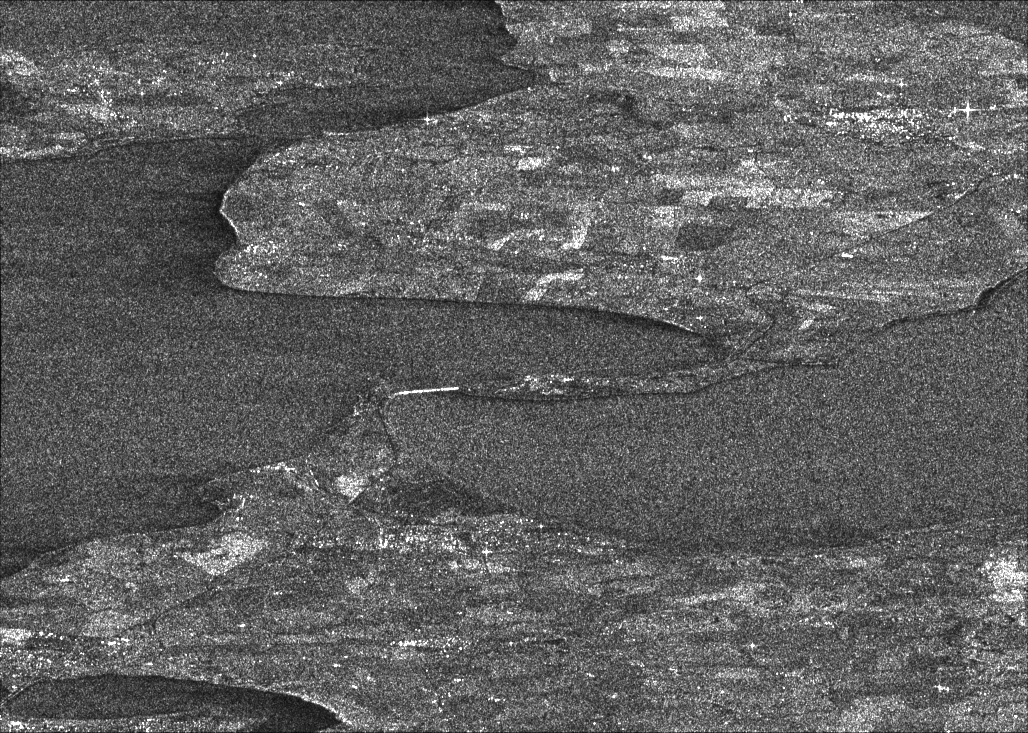

In [219]:
#SlcUtil.show_img(test)

In [16]:
Vs_list = Array{Float64,2}(undef, 17, 3);
for i in 1:17
    Vs_list[i, 1] = parse(Float64, meta_dict["product"]["generalAnnotation"]["orbitList"]["orbit"][i]["velocity"]["x"])
    Vs_list[i, 2] = parse(Float64, meta_dict["product"]["generalAnnotation"]["orbitList"]["orbit"][i]["velocity"]["y"])
    Vs_list[i, 3] = parse(Float64, meta_dict["product"]["generalAnnotation"]["orbitList"]["orbit"][i]["velocity"]["z"])
end

Vs = sqrt.(Vs_list[:, 1].^2 + Vs_list[:, 2].^2 + Vs_list[:, 3].^2);

In [17]:
c = 299792458
t_start = meta["t_start"]
t_stop = meta["t_stop"]
sign_angle  = meta["right_looking"] ? 1 : -1
theta_0 = sign_angle*abs(meta["incidence_angle_mid"]*pi/180)
range_pixel_spacing =  c/(2*meta["range_sampling_rate"])
inv_azimuth_frequency =  1/meta["azimuth_frequency"]
r_near =  meta["slant_range_time"]  *c/2

# time =  t_start + (line_sample[i,1]-1)*inv_azimuth_frequency;

In [18]:
t_0 = meta["t_0"]

#f = open("POD_path.txt")
path = "/Users/eyu/YOEO_local/data/S1B_OPER_AUX_POEORB_OPOD_20170404T111500_V20170314T225942_20170316T005942.EOF"
orbit_state_vector, time_state_vector = Load.precise_orbit(path, t_0);
state_vectors_poly, state_vectors_mean, state_vectors_std = Geometry.satellite_trajectory(orbit_state_vector, time_state_vector, t_start, t_stop);

In [19]:
t_0

2017-03-15T05:39:00

In [14]:
#t0 = meta_dict["product"]["swathTiming"]["burstList"]["burst"][1]["azimuthTime"]
time = 50.703105 + N_l*Delta_t_s/2
x,y,z,vx,vy,vz = Geometry.polyval_state_vectors(state_vectors_poly, time, state_vectors_mean, state_vectors_std)

6-element Array{Float64,1}:
     3.8467338538829894e6
     1.1787061435437116e6
     5.811104859916018e6 
  6356.219716249038      
  -323.60793677337654    
 -4132.110152419239      

In [15]:
vs = sqrt(vx^2 + vy^2 + vz^2)

7588.187233437368